In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_df = pd.read_csv("forecasting_data.csv")

In [4]:
input_df["Date"] = pd.to_datetime(input_df["Date"])
input_df["PRICE_pc"] = input_df["PRICE"].pct_change()

# Data Exploration

In [5]:
input_df.tail()

,Date,PRICE,EARNY,PE,PRICE_pc
1827,2023-04-01,4121.47,4.25,23.53,0.038530
1828,2023-05-01,4146.17,4.22,23.67,0.005993
1829,2023-06-01,4345.37,4.03,24.81,0.048044
1830,2023-07-01,4508.08,3.89,25.74,0.037444
1831,2023-08-01,4546.39,3.85,25.95,0.008498


In [6]:
input_df.isna().sum()

Date        0
PRICE       0
EARNY       0
PE          0
PRICE_pc    1
dtype: int64

In [7]:
input_df.describe()

,PRICE,EARNY,PE,PRICE_pc
count,1832.000000,1832.000000,1832.000000,1831.000000
mean,374.760273,7.262538,16.023788,0.004615
std,802.946503,2.724318,8.474757,0.040593
min,2.730000,0.810000,5.310000,-0.264737
25%,7.930000,5.450000,11.520000,-0.014992
50%,18.060000,6.700000,14.935000,0.006689
75%,185.225000,8.680000,18.352500,0.027656
max,4674.770000,18.820000,123.730000,0.502994


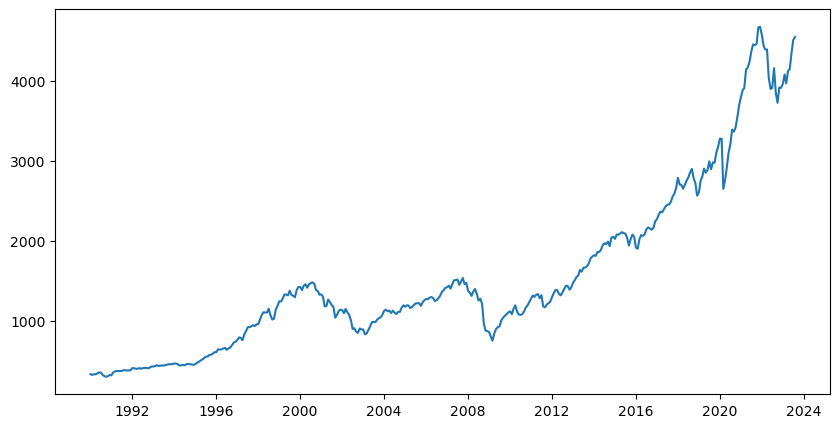

In [8]:
plt_df = input_df.query("Date >= '1990-01-01'")

plt.figure(figsize=(10,5))
plt.plot(plt_df["Date"], plt_df["PRICE"])

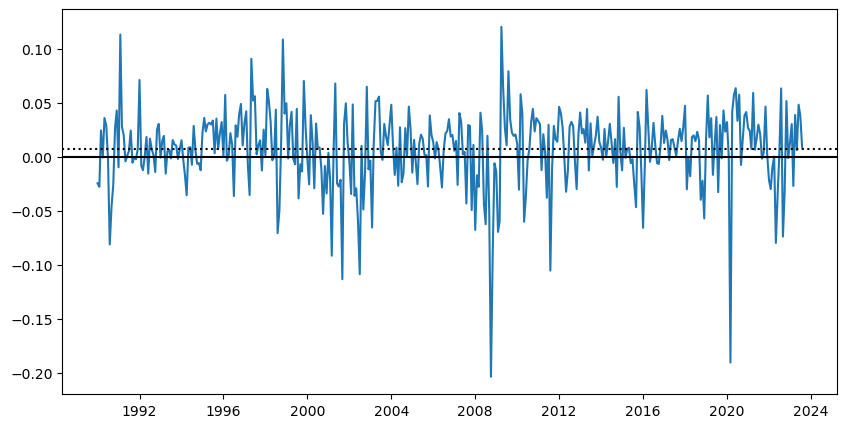

In [14]:
plt.figure(figsize=(10,5))
plt.plot(plt_df["Date"], plt_df["PRICE_pc"])
plt.axhline(y=plt_df["PRICE_pc"].mean(), c="black", ls=":")
plt.axhline(y=0, c="black")

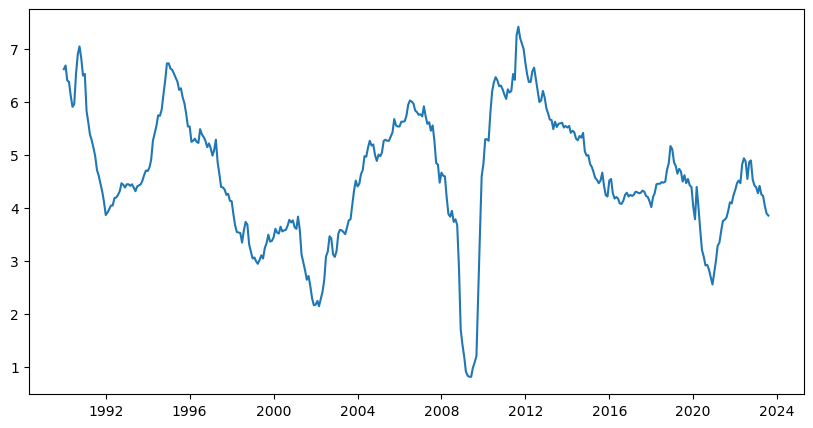

In [10]:
plt.figure(figsize=(10,5))
plt.plot(plt_df["Date"], plt_df["EARNY"])

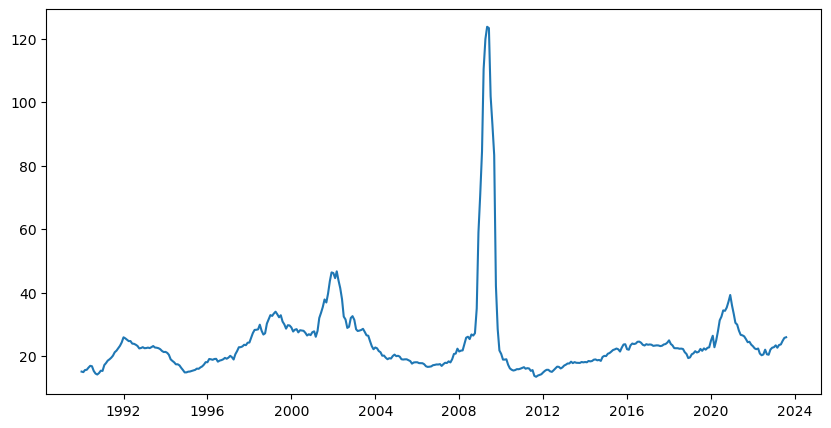

In [11]:
plt.figure(figsize=(10,5))
plt.plot(plt_df["Date"], plt_df["PE"])

In [12]:
input_df.corr(numeric_only=True)

,PRICE,EARNY,PE,PRICE_pc
PRICE,1.000000,-0.433098,0.416076,0.038605
EARNY,-0.433098,1.000000,-0.709555,-0.082825
PE,0.416076,-0.709555,1.000000,0.071120
PRICE_pc,0.038605,-0.082825,0.071120,1.000000


# Feature Engineering

In [49]:
# lagged values
max_lag = 3
data_df = [input_df.copy()]
for lag in range(1, max_lag+1):
    lagged_df = input_df.shift(lag).drop(["Date"], axis=1)
    lagged_df.columns = lagged_df.columns + f"_l{lag}"
    data_df.append(lagged_df)
data_df = pd.concat(data_df, axis=1).dropna()

In [50]:
# date features
data_df["Month"] = data_df["Date"].dt.month
data_df["Year"] = data_df["Date"].dt.year

In [51]:
# binary target (positive/negative growth)
# zero growth considered negative
y_binary = (data_df["PRICE_pc"] > 0).astype(int)

In [52]:
y_binary.mean()

0.5711159737417943

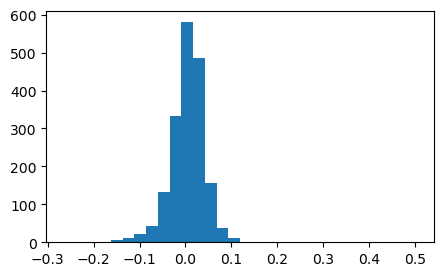

In [53]:
plt.figure(figsize=(5,3))
plt.hist(data_df["PRICE_pc"], bins=30);

In [54]:
# multiple growth categories (quintiles)
y_multi = pd.get_dummies(pd.qcut(data_df["PRICE_pc"], q=5))

In [58]:
# drop contemporaneous features
data_df = data_df.drop(["Date", "PRICE", "EARNY", "PE", "PRICE_pc"], axis=1)

# Train-Test Split, Scaling

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [69]:
train_n = int(data_df.shape[0] * 0.7)
val_n = train_n + int(data_df.shape[0] * 0.15)
print(train_n, val_n)

1279 1553


In [74]:
# Train-Validation-Test splits
X_train, X_val, X_test = data_df.iloc[:train_n], data_df.iloc[train_n:val_n], data_df.iloc[val_n:]
y_train_bin, y_val_bin, y_test_bin = y_binary.iloc[:train_n], y_binary.iloc[train_n:val_n], y_binary.iloc[val_n:]
y_train_mul, y_val_mul, y_test_mul = y_multi.iloc[:train_n], y_multi.iloc[train_n:val_n], y_multi.iloc[val_n:]

In [75]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Model Fitting

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
params = {""}

In [80]:
model_RF_bin = RandomForestClassifier()
model_RF_bin.fit(X_train, y_train_bin)

model_RF_mul = RandomForestClassifier()
model_RF_mul.fit(X_train, y_train_mul)

RandomForestClassifier()

In [82]:
y_val_preds_bin = model_RF_bin.predict(X_val)
y_test_preds_bin = model_RF_bin.predict(X_test)
y_val_preds_mul = model_RF_mul.predict(X_val)
y_test_preds_mul = model_RF_mul.predict(X_test)

# Model Evalution

In [83]:
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score, 
                             precision_score, recall_score, 
                             precision_recall_fscore_support)

In [84]:
def print_scores(y_test, pred):
    print(f'AUC: {roc_auc_score(y_test, pred)}')
    print(f'Accuracy: {accuracy_score(y_test, pred)}')
    print(f'Precision: {precision_score(y_test, pred)}')
    print(f'Recall: {recall_score(y_test, pred)}')

In [85]:
print_scores(y_val_preds_bin, y_val_bin)

AUC: 0.4891439205955335
Accuracy: 0.38686131386861317
Precision: 0.09195402298850575
Recall: 0.6153846153846154


In [86]:
print_scores(y_test_preds_bin, y_test_bin)

AUC: 0.5494071146245059
Accuracy: 0.4
Precision: 0.09142857142857143
Recall: 0.7272727272727273
